In [3]:
# Import necessary libraries
import numpy as np
import os
from PIL import Image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Reshape, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [4]:
def load_dataset(fname=None):
    if fname is None:
        # Assume we are in the utils folder and get the absolute path to the
        # parent directory.
        fname = os.path.abspath(os.path.join(os.path.dirname(__file__),
                                             os.path.pardir))
        fname = os.path.join(fname, 'labels.csv')

    data = np.genfromtxt(fname, dtype=['|S19', '<f8', '|S4'], names=[
                         'path', 'probability', 'type'])
    image_fnames = np.char.decode(data['path'])
    probs = data['probability']
    types = np.char.decode(data['type'])

    def load_cell_image(fname):
        with Image.open(fname) as image:
            return np.asarray(image)

    dir = os.path.dirname(fname)

    images = np.array([load_cell_image(os.path.join(dir, fn))
                       for fn in image_fnames])

    return images, probs, types

In [5]:
def preprocess_and_split(images, probs, types):
    # Add channel dimension for grayscale images
    images_reshaped = np.expand_dims(images, axis=-1)

    # Normalize images
    images_normalized = images_reshaped / 255.0

    # Convert probs to categorical labels
    labels = convert_probs_to_labels(probs)

    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        images_normalized, labels, test_size=0.25, stratify=labels, random_state=42
    )

    return X_train, X_test, y_train, y_test




def convert_probs_to_labels(probs):
    # Convert probabilities to categorical labels
    # 0% -> 3 (fully functional), 33% -> 2 (possibly defective), 
    # 67% -> 1 (likely defective), 100% -> 0 (certainly defective)
    labels = np.round(probs * 3).astype(int)
    labels = 3 - labels  # Invert the scale so that 0% becomes 3 and 100% becomes 0
    return labels



images, probs, types = load_dataset("elpv-dataset-1.0/labels.csv")
X_train, X_test, y_train, y_test = preprocess_and_split(images, probs, types)



In [6]:

# # Load and preprocess the dataset
# images, labels, types = load_preprocessed_dataset()
# 
# # Split the dataset into training and testing
# X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Load the ResNet50 model pre-trained on ImageNet data
# base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

base_model = Sequential([
    # Assuming your input data is of the shape (batch_size, 1, height, width)
    # If your data is in a different format, you might need to adjust the input shape
    # input_shape=(224, 224, 3))
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    # Conv2D(512, kernel_size=(3, 3), activation='relu'),
    # MaxPooling2D(pool_size=(2, 2)),
    # Dropout(0.3),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(4, activation='softmax')  # Using softmax for multi-class classification
])

base_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy', metrics=["accuracy"])  

# Train the model
history = base_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
62/62 [==============================] - 206s 3s/step - loss: 1.2498 - accuracy: 0.5483 - val_loss: 1.0020 - val_accuracy: 0.5808
Epoch 2/10
62/62 [==============================] - 205s 3s/step - loss: 0.9732 - accuracy: 0.6362 - val_loss: 1.2271 - val_accuracy: 0.3140
Epoch 3/10
62/62 [==============================] - 206s 3s/step - loss: 0.9168 - accuracy: 0.6555 - val_loss: 0.8945 - val_accuracy: 0.6997
Epoch 4/10
62/62 [==============================] - 204s 3s/step - loss: 0.8420 - accuracy: 0.6997 - val_loss: 0.8634 - val_accuracy: 0.6997
Epoch 5/10
62/62 [==============================] - 204s 3s/step - loss: 0.8214 - accuracy: 0.7104 - val_loss: 0.8571 - val_accuracy: 0.6966
Epoch 6/10
62/62 [==============================] - 204s 3s/step - loss: 0.7984 - accuracy: 0.7083 - val_loss: 0.8521 - val_accuracy: 0.6982
Epoch 7/10
62/62 [==============================] - 205s 3s/step - loss: 0.7741 - accuracy: 0.7200 - val_loss: 0.8260 - val_accuracy: 0.6997
Epoch 8/10
62

In [21]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Predict the test set results
y_pred = base_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert y_test from one-hot encoding to class indices

# print(y_test)
# print(y_pred_classes)
# y_test_classes = np.argmax(y_test, axis=1)
y_test_classes=y_test

# print(y_test_classes)

# Now calculate the confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)
print("Confusion Matrix:")
print(cm)

# Similarly, adjust the classification report
report = classification_report(y_test_classes, y_pred_classes, target_names=['Fully Functional', 'Possibly Defective', 'Likely Defective', 'Certainly Defective'])
print("\nClassification Report:")
print(report)



21/21 [==============================] - 6s 296ms/step
Confusion Matrix:
[[ 99   0   1  79]
 [  4   0   1  21]
 [  8   0   6  60]
 [ 22   0   0 355]]

Classification Report:
                     precision    recall  f1-score   support

   Fully Functional       0.74      0.55      0.63       179
 Possibly Defective       0.00      0.00      0.00        26
   Likely Defective       0.75      0.08      0.15        74
Certainly Defective       0.69      0.94      0.80       377

           accuracy                           0.70       656
          macro avg       0.55      0.39      0.39       656
       weighted avg       0.68      0.70      0.65       656


c:\users\haomi\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\haomi\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\haomi\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

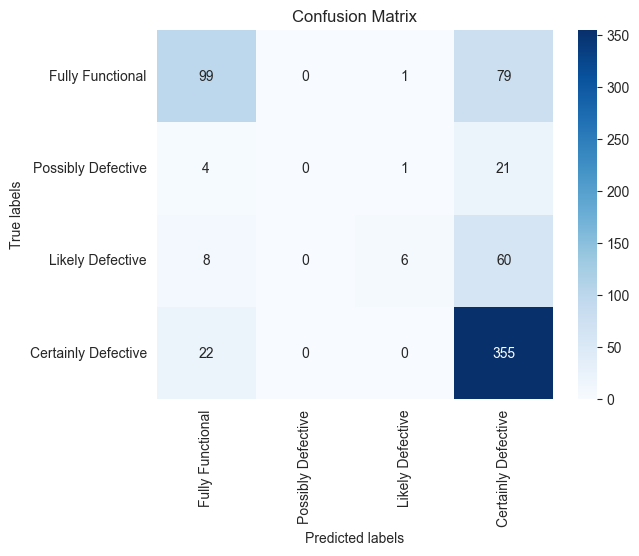

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion Matrix
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Fully Functional', 'Possibly Defective', 'Likely Defective', 'Certainly Defective'], yticklabels=['Fully Functional', 'Possibly Defective', 'Likely Defective', 'Certainly Defective'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

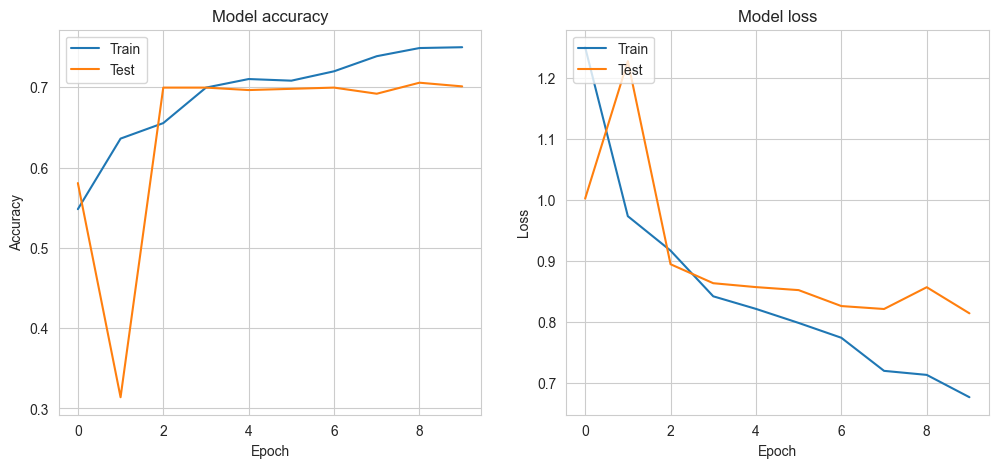

In [23]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [25]:

from sklearn.metrics import classification_report
import pandas as pd

# Convert y_test from one-hot encoding to class indices
# y_test_classes = np.argmax(y_test, axis=1)

# Generate the classification report
report = classification_report(y_test_classes, y_pred_classes,
                               target_names=['Fully Functional', 'Possibly Defective', 'Likely Defective',
                                             'Certainly Defective'], output_dict=True)

# Convert to DataFrame
report_df = pd.DataFrame(report).transpose()

c:\users\haomi\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\haomi\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\haomi\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

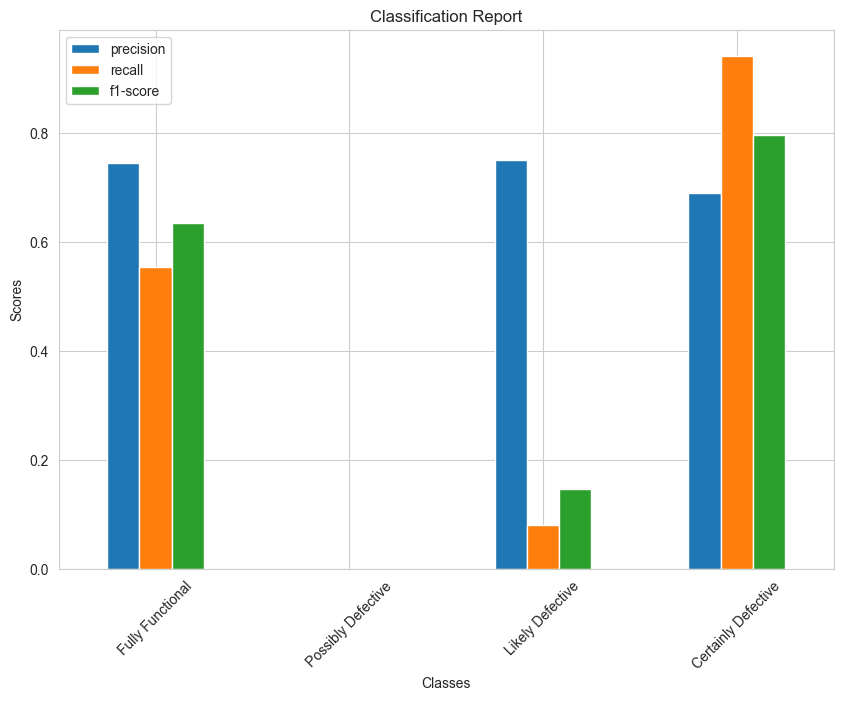

In [26]:
# Drop the support row
report_df = report_df.drop('support', axis=1)

# Plotting
report_df[:-3].plot(kind='bar', figsize=(10, 7))
plt.title('Classification Report')
plt.xlabel('Classes')
plt.ylabel('Scores')
plt.xticks(rotation=45)
plt.show()


In [75]:
mono_images=[]
mono_probs=[]
mono_types=[]

for index in range(0,len(types)):
    if types[index] == "mono":
        mono_images.append(images[index])
        mono_probs.append(probs[index])
        mono_types.append(types[index])

# Add channel dimension for grayscale images
images_reshaped = np.expand_dims(mono_images, axis=-1)

# Normalize images
images_normalized = images_reshaped / 255.0


def test_convert_probs_to_labels(probs):
    # Ensure probs is a numpy array
    probs = np.array(probs)

    # Scale and invert the probabilities to get labels
    labels = 3 - np.round(probs * 3).astype(int)

    return labels

# Convert probs to categorical labels
mono_labels = test_convert_probs_to_labels(mono_probs)


# Split into training and testing sets
mono_X_train, mono_X_test, mono_y_train, mono_y_test = train_test_split(
    images_normalized, mono_labels, test_size=0.25, stratify=mono_labels, random_state=42
)



In [76]:
# Predict the test set results
mono_y_pred = base_model.predict(mono_X_test)
mono_y_pred_classes = np.argmax(mono_y_pred, axis=1)

# Convert y_test from one-hot encoding to class indices
mono_y_test_classes = mono_y_test

# Now calculate the confusion matrix
mono_cm = confusion_matrix(mono_y_test_classes, mono_y_pred_classes)
print("Confusion Matrix:")
print(mono_cm)

# Similarly, adjust the classification report
mono_report = classification_report(mono_y_test_classes, mono_y_pred_classes, target_names=['Fully Functional', 'Possibly Defective', 'Likely Defective', 'Certainly Defective'])
print("\nClassification Report:")
print(mono_report)

9/9 [==============================] - 3s 305ms/step
Confusion Matrix:
[[ 53   0   1  25]
 [  2   0   1  11]
 [  3   0   0  26]
 [  7   0   0 140]]

Classification Report:
                     precision    recall  f1-score   support

   Fully Functional       0.82      0.67      0.74        79
 Possibly Defective       0.00      0.00      0.00        14
   Likely Defective       0.00      0.00      0.00        29
Certainly Defective       0.69      0.95      0.80       147

           accuracy                           0.72       269
          macro avg       0.38      0.41      0.38       269
       weighted avg       0.62      0.72      0.65       269


c:\users\haomi\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\haomi\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\haomi\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [78]:
poly_images=[]
poly_probs=[]
poly_types=[]

for index in range(0,len(types)):
    if types[index] == "poly":
        poly_images.append(images[index])
        poly_probs.append(probs[index])
        poly_types.append(types[index])

# Add channel dimension for grayscale images
images_reshaped = np.expand_dims(poly_images, axis=-1)

# Normalize images
images_normalized = images_reshaped / 255.0

# Convert probs to categorical labels
poly_labels = test_convert_probs_to_labels(poly_probs)


# Split into training and testing sets
poly_X_train, poly_X_test, poly_y_train, poly_y_test = train_test_split(
    images_normalized, poly_labels, test_size=0.25, stratify=poly_labels, random_state=42
)



In [79]:
poly_y_pred = base_model.predict(poly_X_test)
poly_y_pred_classes = np.argmax(poly_y_pred, axis=1)

# Convert y_test from one-hot encoding to class indices
poly_y_test_classes = poly_y_test

# Now calculate the confusion matrix
poly_cm = confusion_matrix(poly_y_test_classes, poly_y_pred_classes)
print("Confusion Matrix:")
print(poly_cm)

# Similarly, adjust the classification report
poly_report = classification_report(poly_y_test_classes, poly_y_pred_classes, target_names=['Fully Functional', 'Possibly Defective', 'Likely Defective', 'Certainly Defective'])
print("\nClassification Report:")
print(poly_report)

13/13 [==============================] - 4s 293ms/step
Confusion Matrix:
[[ 64   0   1  36]
 [  6   0   1   5]
 [  6   0  17  22]
 [  6   0   1 223]]

Classification Report:
                     precision    recall  f1-score   support

   Fully Functional       0.78      0.63      0.70       101
 Possibly Defective       0.00      0.00      0.00        12
   Likely Defective       0.85      0.38      0.52        45
Certainly Defective       0.78      0.97      0.86       230

           accuracy                           0.78       388
          macro avg       0.60      0.50      0.52       388
       weighted avg       0.76      0.78      0.76       388


c:\users\haomi\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\haomi\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\haomi\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo